In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, BatchNormalization,MaxPooling2D, concatenate, Dropout, Lambda, RepeatVector
from tensorflow.keras.models import Model, Sequential, load_model
import numpy as np
import os
import tensorflow as tf
import cv2
import imutils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping
from random import choice
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [ ]:
!unzip /content/drive/MyDrive/DATASET.zip

In [ ]:

image_size=(64,64)
code={"EOSINOPHIL":0,"LYMPHOCYTE":1,"MONOCYTE":2,"NEUTROPHIL":3}

images = []
vectors = []
labels = []

def findedges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getimageconturs(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def getboxes(contours,orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (np.linalg.norm(tl - bl)) > 0 and (np.linalg.norm(tl - tr)) > 0:
            boxes.append(box)
    return boxes

def getcode(n):
    if type(n)==str:
        for x,y in code.items():
            if n==x:
                return y
    else:
        for x,y in code.items():
            if n==y:
                return x

In [ ]:
def load_and_preprocess_data(images_path, path):

    for label, folder_path in enumerate(path):
        vec_files = os.listdir(folder_path)
        for vec_file in vec_files:
            filename = vec_file.split(".")[0]
            class_name = getcode(label)

            image_path = f"{images_path}/{class_name}/{filename}.jpeg"
            vector_path = f"{folder_path}{vec_file}"

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # add padding to the image to better detect cell at the edge
            image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])

            #thresholding the image to get the target cell
            image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))

            # openning errosion then dilation
            kernel = np.ones((3, 3), np.uint8)
            kernel1 = np.ones((5, 5), np.uint8)
            img_erosion = cv2.erode(image1, kernel, iterations=2)
            image1 = cv2.dilate(img_erosion, kernel1, iterations=5)

            #detecting the blood cell
            edgedImage = findedges(image1)
            edgedContours = getimageconturs(edgedImage)
            edgedBoxes =  getboxes(edgedContours, image.copy())

            if len(edgedBoxes)==0:
                continue
            # get the large box and get its cordinate
            last = edgedBoxes[-1]
            max_x = int(max(last[:,0]))
            min_x = int( min(last[:,0]))
            max_y = int(max(last[:,1]))
            min_y = int(min(last[:,1]))

            # draw the contour and fill it
            mask = np.zeros_like(image)
            cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1)

            # any pixel but the pixels inside the contour is zero
            image[mask==0] = 0

            # extract th blood cell
            image = image[min_y:max_y, min_x:max_x]

            if (np.size(image)==0):
                continue
            # resize th image

            image = cv2.resize(image, image_size)
            image = image / 255.0  # Normalize pixel values to [0, 1]

            vector = np.loadtxt(vector_path, delimiter=',')

            images.append(image)
            vectors.append(vector)
            labels.append(label)

In [ ]:
paths = [
    '/content/DATASET/TRAIN/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TRAIN/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/MONOCYTE/',
    '/content/DATASET/TRAIN/VECTORS/NEUTROPHIL/'
]

test_paths = [
    '/content/DATASET/TEST/VECTORS/EOSINOPHIL/',
    '/content/DATASET/TEST/VECTORS/LYMPHOCYTE/',
    '/content/DATASET/TEST/VECTORS/MONOCYTE/',
    '/content/DATASET/TEST/VECTORS/NEUTROPHIL/'
]

In [ ]:
load_and_preprocess_data("/content/DATASET/TRAIN/IMAGES", paths)
load_and_preprocess_data("/content/DATASET/TEST/IMAGES", test_paths)

In [ ]:
images = np.array(images)
vectors = np.array(vectors)
labels = np.array(labels)

In [ ]:
print(len(images), len(vectors), len(labels))

12146 12146 12146


In [ ]:
images,vectors,labels=shuffle(images,vectors,labels,random_state=10)

In [ ]:
# Generate Train and Test using 80/20 split
images_train, images_test, vectors_train, vectors_test, labels_train, labels_test = train_test_split(images, vectors, labels, test_size=0.2, random_state=42)

In [ ]:
print(images_train.shape, labels_train.shape, vectors_train.shape)
print(images_test.shape, labels_test.shape, vectors_test.shape)

(9716, 64, 64, 3) (9716,) (9716, 10)
(2430, 64, 64, 3) (2430,) (2430, 10)


In [ ]:
model_path = "/content/drive/MyDrive/BCCD_Models/vector_predictor_v64.h5"
vector_predictor = load_model(model_path)

In [ ]:
def predict_vec(img):
  input_data = np.expand_dims(img, axis=0)
  return np.round(vector_predictor.predict(input_data, verbose=0)[0])

# **WBC State Transition Graph**

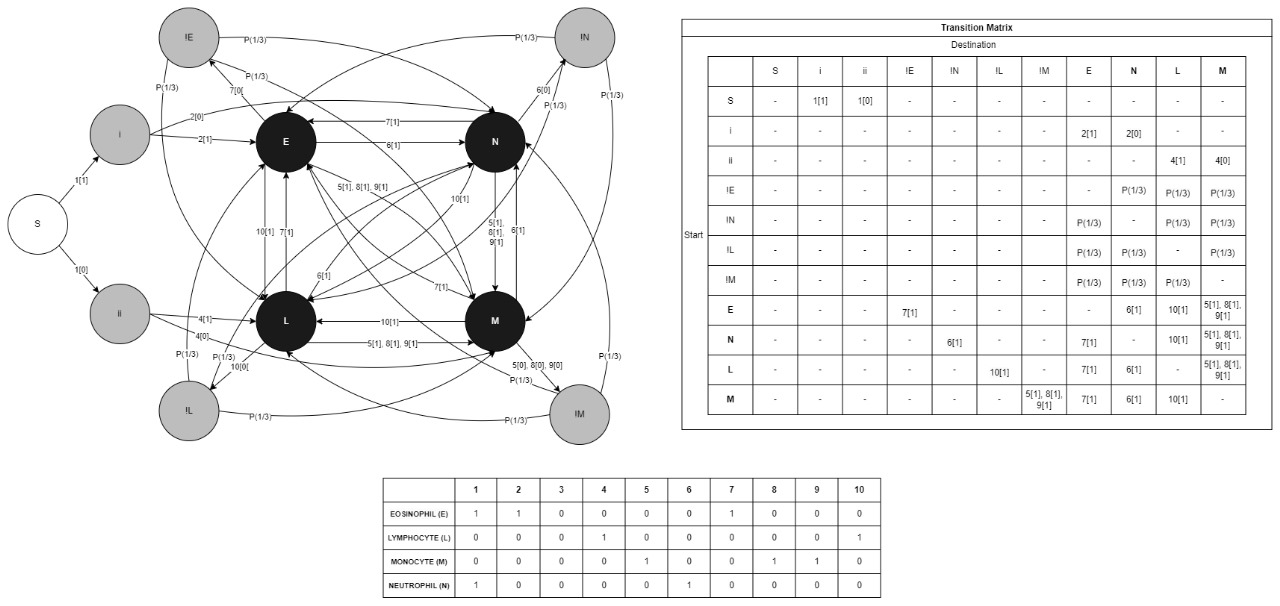

In [ ]:
adjacency_matrix = [
      #S  i  j  e  n  l  m  E  N  L  M
      [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], # S
      [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], # i
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], # j
      [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], # e
      [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], # n
      [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1], # l
      [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], # m
      [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], # E
      [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1], # N
      [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], # L
      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]  # M
  ]

In [ ]:
def get_transition_matrix(vec):
  # Note: Using zero indexing

  transition_matrix = [
      [None, vec[0] == 1, vec[0] == 0, None, None, None, None, None, None, None, None],
      [None, None, None, None, None, None, None, vec[1] == 1, vec[1] == 0, None, None],
      [None, None, None, None, None, None, None, None, None, vec[3] == 1, vec[3] == 0],
      [None, None, None, None, None, None, None, None, -1, -1, -1],
      [None, None, None, None, None, None, None, -1, None, -1, -1],
      [None, None, None, None, None, None, None, -1, -1, None, -1],
      [None, None, None, None, None, None, None, -1, -1, -1, None],
      [None, None, None, vec[6] == 0, None, None, None, None, vec[5] == 1, vec[9] == 1, vec[4] == 1 or vec[7] == 1 or vec[8] == 1],
      [None, None, None, None, vec[5] == 0, None, None, vec[6] == 1, None, vec[9] == 1, vec[4] == 1 or vec[7] == 1 or vec[8] == 1],
      [None, None, None, None, None, vec[9] == 0, None, vec[6] == 1, vec[5] == 1, None, vec[4] == 1 or vec[7] == 1 or vec[8] == 1],
      [None, None, None, None, None, None, vec[4] == 0 or vec[7] == 0 or vec[8] == 0, vec[6] == 1, vec[5] == 1, vec[9] == 1, None]
  ]

  return transition_matrix

In [ ]:
def can_transition(transition_matrix, current_state, i):
  status = transition_matrix[current_state][i]

  if status == None:
    return (False, current_state)
  elif status == -1:
    return (True, random_transition(current_state))
  else:
    return (status, i)

In [ ]:
def random_transition(current_state):
  #3 --> !E
  #4 --> !N
  #5 --> !L
  #6 --> !M
  #7 --> E
  #8 --> N
  #9 --> L
  #10 --> M

  if(current_state == 3): #!E
    return choice([8, 9, 10])
  elif(current_state == 4): #!N
    return choice([7, 9, 10])
  elif(current_state == 5): #!L
    return choice([7, 8, 10])
  elif(current_state == 6): #!M
    return choice([7, 8, 9])

In [ ]:
def traverse(vec):
  visited = []
  prev_state = 0 #S
  current_state = 0 # S
  transition_matrix = get_transition_matrix(vec)
  print(f"{current_state} --> ", end="")

  while(True):
    for i in range(len(adjacency_matrix[current_state])):

      if(adjacency_matrix[current_state][i] == 1):
        transition_status, next_state = can_transition(transition_matrix, current_state, i)
        if next_state in visited:
          print(f"--> Already in visited: {next_state} ", end="")
          return next_state

        if(transition_status == True):
          print(f"{i} --> ", end="")
          prev_state = current_state
          current_state = next_state
          visited.append(current_state)
          break
    else:
      break

  print("Done")
  return current_state

In [ ]:
def translate_graph_final_state(state, label_name=False):
  wbcs=["EOSINOPHIL", "NEUTROPHIL", "LYMPHOCYTE", "MONOCYTE"]
  return wbcs[state - 7] if label_name else getcode(wbcs[state - 7])

In [ ]:
def traversal_prediction(img, translate=False):
  vec = predict_vec(img)
  print(f"Vector: {vec}")
  final_state = traverse(vec)
  return translate_graph_final_state(final_state, translate)

In [ ]:
predicted_labels = []
for i in range(len(images_test)):
  print(f"Current Index: {i} ------- ", end="")
  predicted_labels.append(traversal_prediction(images_test[i]))

Current Index: 0 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 1 ------- Vector: [1. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
0 --> 1 --> 7 --> Done
Current Index: 2 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 3 ------- Vector: [0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
0 --> 2 --> 10 --> Done
Current Index: 4 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 5 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 6 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 7 ------- Vector: [0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
0 --> 2 --> 10 --> Done
Current Index: 8 ------- Vector: [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
0 --> 2 --> 9 --> Done
Current Index: 9 ------- Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
Current Index: 10 ------- Vector: [0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
0 --> 2 --> 10 --> Done
Current Index: 11 ------- Ve

In [ ]:
i = random.randint(0, len(predicted_labels) - 1)
print(i)
print(traversal_prediction(images_test[i], True))
print(getcode(labels_test[i]))

709
Vector: [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 --> 1 --> 8 --> Done
NEUTROPHIL
NEUTROPHIL


In [ ]:
report = classification_report(labels_test, predicted_labels)
accuracy = accuracy_score(labels_test, predicted_labels)
conf_matrix = confusion_matrix(labels_test, predicted_labels)

print(report)
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       620
           1       1.00      1.00      1.00       622
           2       0.99      1.00      1.00       590
           3       0.99      0.98      0.98       598

    accuracy                           0.99      2430
   macro avg       0.99      0.99      0.99      2430
weighted avg       0.99      0.99      0.99      2430

Accuracy: 0.991358024691358

Confusion Matrix:
[[613   0   1   6]
 [  0 622   0   0]
 [  0   0 589   1]
 [  9   1   3 585]]
